# Анализ поведения клиентов на примере сайта GB

**Задача:** провести анализ логов с сайта GB, рассчитать некоторые из метрик и выявить инсайты, которые могут быть полезны бизнесу.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, balanced_accuracy_score, \
#                             confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.impute import SimpleImputer
# from sklearn.pipeline import Pipeline, make_pipeline

sns.set()
%matplotlib inline

**Данные:** логи сайта

In [2]:
fields_description = pd.read_excel('Описание полей.xlsx', sheet_name='Лист1')
with pd.option_context("display.max_colwidth", 1000):
    display(fields_description)

,Поле,Описание
0,session_id,идентификатор сессии
1,claim,"признак наличия отправки формы заявки во вемя текущей сессии (0 – нет заявки, 1 – заявка отправлена)"
2,60sec,"признак длительности сессии 60 секунд и более (0 – сессия менее 60 сек, 1 – сессия 60 сек и более)"
3,scroll_90,"признак вертикальной прокрутки страницы глубиной 90% (0 – прокрутка менее 90%, 1 – прокрутка 90% и более)"
4,hit_date,дата сессии
5,referer_url,адрес реферера страницы просмотра
6,url,адрес страницы просмотра
7,utm_source,utm-метка источника
8,utm_medium,utm-метка канала
9,gender,"пол посетителя из куки (-1 – не определен, 0 – мужской, 1 – женский)"


# 1. Загрузка данных. Проверка корректности типов данных

In [3]:
gb_data = pd.read_csv("Датасет GB.csv", parse_dates=['hit_date'])
gb_data.sample(n=10, random_state=42)

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
211668,d576f188be08d2d8,0,1,0,2021-12-01,https://gb.ru/lessons/193687,https://gb.ru/login,NaN,NaN,0,56,1,1,1
448502,c01433a86f61f0cc,0,0,0,2021-12-02,https://gb.ru/,https://gb.ru/,NaN,NaN,0,21,1,1,0
865684,873ca700e761e7fb,0,0,1,2021-12-04,https://gb.ru/education,https://gb.ru/comms/chat,NaN,NaN,-1,-1,2,0,0
808919,a028b9648f72333d,0,1,0,2021-12-04,https://gb.ru/career-masterskaya,https://gb.ru/posts,NaN,NaN,-1,-1,2,1,0
48333,4d79bcf3f86b6a19,0,0,0,2021-12-01,NaN,https://gb.ru/login,NaN,NaN,-1,-1,1,0,0
85545,17d85e20375a0f4e,0,0,0,2021-12-01,NaN,https://gb.ru/,NaN,NaN,-1,-1,1,0,0
731773,4d42a5126d23ea99,0,0,0,2021-12-04,https://gb.ru/,https://gb.ru/education,NaN,NaN,0,29,2,1,1
784572,e4c808f66df24ee1,0,0,1,2021-12-04,https://m.vk.com/feed,https://gb.ru/s/edufree/besplatno,mt,cpc,1,37,2,1,1
130904,6a8336732d079141,0,1,1,2021-12-01,https://gb.ru/courses,https://gb.ru/geek_university/e-commerce,NaN,NaN,-1,-1,1,0,0
708148,c8bda4f6332843da,0,1,0,2021-12-04,https://www.google.com/,https://gb.ru/posts/tts_python,NaN,NaN,-1,-1,1,1,0


In [4]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    884407 non-null  object        
 1   claim         884407 non-null  int64         
 2   60sec         884407 non-null  int64         
 3   scroll_90     884407 non-null  int64         
 4   hit_date      884407 non-null  datetime64[ns]
 5   referer_url   687598 non-null  object        
 6   url           884407 non-null  object        
 7   utm_source    245184 non-null  object        
 8   utm_medium    244863 non-null  object        
 9   gender        884407 non-null  int64         
 10  age           884407 non-null  int64         
 11  touch_screen  884407 non-null  int64         
 12  has_vk_id     884407 non-null  int64         
 13  has_ok_id     884407 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(5)
memory usage: 94.5+ MB


In [5]:
bool_features = ['has_vk_id', 'has_ok_id', '60sec', 'scroll_90', 'claim']  # бинарные признаки
cat_features = ['touch_screen', 'gender']  # категориальные признаки
# num_features = list(set(gb_data.select_dtypes(exclude='object').columns)
#                     - set(bool_features) - set(cat_features))  # числовые признаки
obj_features = gb_data.select_dtypes(include='object').columns.to_list()  # текстовые признаки  
bool_features, cat_features, obj_features  # , num_features

(['has_vk_id', 'has_ok_id', '60sec', 'scroll_90', 'claim'],
 ['touch_screen', 'gender'],
 ['session_id', 'referer_url', 'url', 'utm_source', 'utm_medium'])

In [6]:
gb_data[bool_features] = gb_data[bool_features].astype(bool)
gb_data[cat_features] = gb_data[cat_features].astype('category')
gb_data['age'] = gb_data['age'].astype('int8')

In [7]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    884407 non-null  object        
 1   claim         884407 non-null  bool          
 2   60sec         884407 non-null  bool          
 3   scroll_90     884407 non-null  bool          
 4   hit_date      884407 non-null  datetime64[ns]
 5   referer_url   687598 non-null  object        
 6   url           884407 non-null  object        
 7   utm_source    245184 non-null  object        
 8   utm_medium    244863 non-null  object        
 9   gender        884407 non-null  category      
 10  age           884407 non-null  int8          
 11  touch_screen  884407 non-null  category      
 12  has_vk_id     884407 non-null  bool          
 13  has_ok_id     884407 non-null  bool          
dtypes: bool(5), category(2), datetime64[ns](1), int8(1), object(5)
memor

In [8]:
gb_data.sample(n=10, random_state=42)

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
211668,d576f188be08d2d8,False,True,False,2021-12-01,https://gb.ru/lessons/193687,https://gb.ru/login,NaN,NaN,0,56,1,True,True
448502,c01433a86f61f0cc,False,False,False,2021-12-02,https://gb.ru/,https://gb.ru/,NaN,NaN,0,21,1,True,False
865684,873ca700e761e7fb,False,False,True,2021-12-04,https://gb.ru/education,https://gb.ru/comms/chat,NaN,NaN,-1,-1,2,False,False
808919,a028b9648f72333d,False,True,False,2021-12-04,https://gb.ru/career-masterskaya,https://gb.ru/posts,NaN,NaN,-1,-1,2,True,False
48333,4d79bcf3f86b6a19,False,False,False,2021-12-01,NaN,https://gb.ru/login,NaN,NaN,-1,-1,1,False,False
85545,17d85e20375a0f4e,False,False,False,2021-12-01,NaN,https://gb.ru/,NaN,NaN,-1,-1,1,False,False
731773,4d42a5126d23ea99,False,False,False,2021-12-04,https://gb.ru/,https://gb.ru/education,NaN,NaN,0,29,2,True,True
784572,e4c808f66df24ee1,False,False,True,2021-12-04,https://m.vk.com/feed,https://gb.ru/s/edufree/besplatno,mt,cpc,1,37,2,True,True
130904,6a8336732d079141,False,True,True,2021-12-01,https://gb.ru/courses,https://gb.ru/geek_university/e-commerce,NaN,NaN,-1,-1,1,False,False
708148,c8bda4f6332843da,False,True,False,2021-12-04,https://www.google.com/,https://gb.ru/posts/tts_python,NaN,NaN,-1,-1,1,True,False


# 2. Исследовательский анализ данных

**Разведочный анализ данных** (exploratory data analysis, EDA) — предварительный анализ данных для определения общих закономерностей и свойств. Понятие введено математиком Джоном Тьюки.  
Цели анализа:  
* Максимальное «проникновение» в данные
* Выявление основных структур
* Выбор наиболее важных переменных
* Обнаружение отклонений и аномалий
* Проверка основных гипотез
* Разработка начальных моделей

In [9]:
gb_data.describe(include='all', datetime_is_numeric=False)

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
count,884407,884407,884407,884407,884407,687598,884407,245184,244863,884407.0,884407.000000,884407.0,884407,884407
unique,864092,2,2,2,4,42580,13477,183,69,3.0,NaN,2.0,2,2
top,8bf8f70b50764dbc,False,False,False,2021-12-02 00:00:00,https://gb.ru/,https://gb.ru/education,mt,cpc,-1.0,NaN,1.0,False,False
freq,5,882575,607212,756878,250158,112879,150196,115503,178809,505397.0,NaN,498534.0,486866,774702
first,NaN,NaN,NaN,NaN,2021-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2021-12-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.844552,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.505421,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN


In [10]:
gb_data.describe(include='bool')

,claim,60sec,scroll_90,has_vk_id,has_ok_id
count,884407,884407,884407,884407,884407
unique,2,2,2,2,2
top,False,False,False,False,False
freq,882575,607212,756878,486866,774702


In [11]:
gb_data.describe(include='category')

,gender,touch_screen
count,884407,884407
unique,3,2
top,-1,1
freq,505397,498534


In [12]:
gb_data.describe(include='object')

,session_id,referer_url,url,utm_source,utm_medium
count,884407,687598,884407,245184,244863
unique,864092,42580,13477,183,69
top,8bf8f70b50764dbc,https://gb.ru/,https://gb.ru/education,mt,cpc
freq,5,112879,150196,115503,178809


In [13]:
gb_data.describe(include='datetime64')

,hit_date
count,884407
unique,4
top,2021-12-02 00:00:00
freq,250158
first,2021-12-01 00:00:00
last,2021-12-04 00:00:00


In [14]:
gb_data.describe()

,age
count,884407.000000
mean,14.844552
std,21.505421
min,-1.000000
25%,-1.000000
50%,-1.000000
75%,29.000000
max,120.000000


In [15]:
# # количество уникальных значений для каждого поля
# for field in list(fields_description['Поле']):
#     print(f"{field}: {len(gb_data[field].unique())}")

In [16]:
for field in bool_features + cat_features + ['hit_date']:
    print(gb_data[field].value_counts(normalize=True), end='\n\n')

False    0.5505
True     0.4495
Name: has_vk_id, dtype: float64

False    0.875956
True     0.124044
Name: has_ok_id, dtype: float64

False    0.686575
True     0.313425
Name: 60sec, dtype: float64

False    0.855803
True     0.144197
Name: scroll_90, dtype: float64

False    0.997929
True     0.002071
Name: claim, dtype: float64

1    0.563693
2    0.436307
Name: touch_screen, dtype: float64

-1    0.571453
0     0.216550
1     0.211997
Name: gender, dtype: float64

2021-12-02    0.282854
2021-12-01    0.257489
2021-12-04    0.239297
2021-12-03    0.220360
Name: hit_date, dtype: float64



# 3. Статистический анализ данных

Статистический анализ данных:
* Анализ агрегированных характеристик (среднего значения, моды, медианы и так далее)
* Выявление аномалий с помощью статистических методов (например, IQR (метод межквартильных расстояний))
* Анализ типа распределения признаков
* Проверка гипотез (проведение статистических тестов)

In [17]:
gb_data.groupby(by=['hit_date']).sum()[bool_features]

,has_vk_id,has_ok_id,60sec,scroll_90,claim
hit_date,,,,,
2021-12-01,102008,28169,72162,32586,520
2021-12-02,112273,30091,77657,37005,543
2021-12-03,87617,24647,60975,26476,497
2021-12-04,95643,26798,66401,31462,272


In [18]:
gb_data[gb_data['age'] > 0].groupby("touch_screen")['age'].mean()

touch_screen
1    34.226886
2    39.473903
Name: age, dtype: float64

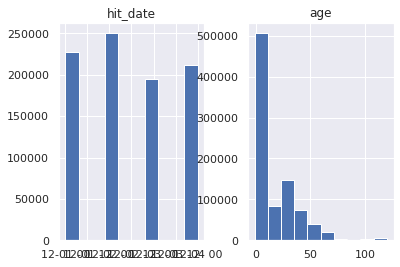

In [19]:
gb_data.hist();

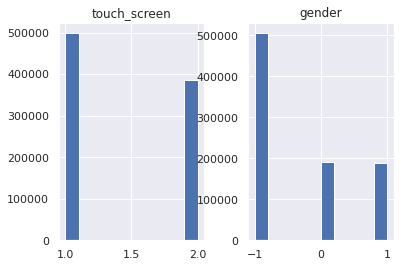

In [20]:
gb_data[cat_features].astype(int).hist();

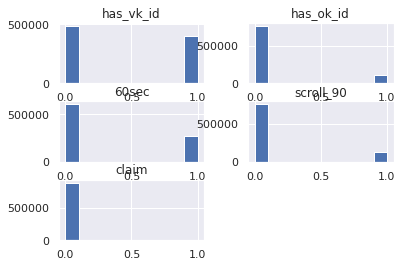

In [21]:
gb_data[bool_features].astype(int).hist();

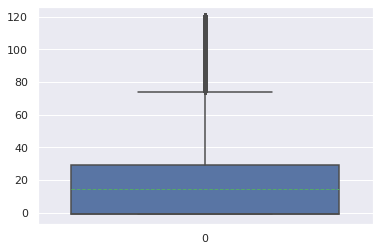

In [22]:
# gb_data[['age']].boxplot();
sns.boxplot(data=gb_data['age'], showmeans=True, meanline=True);

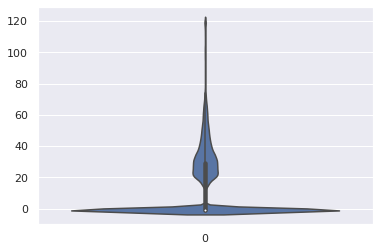

In [23]:
sns.violinplot(data=gb_data['age']);

# 4. Предобработка данных (обработка пропусков, аномалий)

## Заполнение пропусков

In [24]:
cols_with_missing = [col for col in gb_data.columns if gb_data[col].isnull().any()]
for col in cols_with_missing:
    gb_data[col + '_undef'] = gb_data[col].isnull()
imputer = SimpleImputer(strategy="constant", fill_value="UNKNOWN")
columns = gb_data.columns.copy()
gb_data[obj_features] = pd.DataFrame(imputer.fit_transform(gb_data[obj_features]))
gb_data.columns = columns
# gb_data = gb_data.drop(cols_with_missing, axis=1)
gb_data.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,utm_medium_undef
0,4358a11f0d16be6e,False,False,True,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,UNKNOWN,UNKNOWN,0,39,1,True,False,False,True,True
1,133509b7ff9a586c,False,False,False,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,False,False,False,False,False
2,8b23cd36f2b08dcd,False,False,False,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,UNKNOWN,UNKNOWN,1,49,1,True,True,False,True,True
3,50de4c060fd128f3,False,True,True,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,UNKNOWN,UNKNOWN,-1,-1,1,True,False,False,True,True
4,c2ca3cc9a67c749b,False,False,False,2021-12-01,UNKNOWN,https://gb.ru/login,UNKNOWN,UNKNOWN,0,23,2,True,False,True,True,True


## Преобразование категориальных признаков

In [25]:
# ordinal = OrdinalEncoder()
# gb_data[['utm_source', 'utm_medium']] = ordinal.fit_transform(gb_data[['utm_source', 'utm_medium']])
# gb_data.head()

## Проектирование новых признаков

In [26]:
gb_data['gender_M'] = (gb_data['gender'] == 0).astype(bool)
gb_data['gender_F'] = (gb_data['gender'] == 1).astype(bool)
gb_data['gender_0'] = (gb_data['gender'] == -1).astype(bool)
gb_data.drop('gender', axis=1, inplace=True)

In [27]:
ranges = [-1, 0, 13, 18, 35, 60, 80, 125, 200]
labels = None  # ['unknown', 'child', 'teen', 'youth', 'middle', 'old', 'antique', 'unreal']
agebins = pd.cut(list(gb_data['age']), bins=ranges, right=False, labels=labels)
agebins.describe()
# print(agebins.describe().sum())

,counts,freqs
categories,,
"[-1, 0)",505397,0.571453
"[0, 13)",761,0.000860
"[13, 18)",14912,0.016861
"[18, 35)",206809,0.233839
"[35, 60)",124151,0.140378
"[60, 80)",23114,0.026135
"[80, 125)",9263,0.010474
"[125, 200)",0,0.000000


In [28]:
gb_data['age_child'] = ((0 <= gb_data['age']) & (gb_data['age'] < 13)).astype(bool)
gb_data['age_teen'] = ((13 <= gb_data['age']) & (gb_data['age'] < 18)).astype(bool)
gb_data['age_youth'] = ((18 <= gb_data['age']) & (gb_data['age'] < 35)).astype(bool)
gb_data['age_middle'] = ((35 <= gb_data['age']) & (gb_data['age'] < 60)).astype(bool)
gb_data['age_old'] = ((60 <= gb_data['age']) & (gb_data['age'] < 80)).astype(bool)
gb_data['age_antique'] = ((80 <= gb_data['age']) & (gb_data['age'] < 125)).astype(bool)
gb_data['age_unknown'] = (gb_data['age'] < 0).astype(bool)
# gb_data.drop('age', axis=1, inplace=True)

In [29]:
hit_date = pd.to_datetime(gb_data['hit_date'])
gb_data['hit_date'] = hit_date  # hit_date.dt.strftime("%Y-%m-%d (%a)")
gb_data['weekday'] = pd.Categorical(hit_date.dt.day_name())  # gb_data['hit_date'].dt.day_name()  # день недели
gb_data['weekend'] = hit_date.dt.day_name().isin(['Saturday', 'Sunday']).astype(bool)  # выходной день

In [30]:
obj_val_cnts = {}
for key in ('referer_url', 'url', 'utm_source', 'utm_medium'):
    obj_val_cnts[key] = gb_data[key].value_counts().to_dict()

In [31]:
# urls = gb_data['referer_url'].copy()
# urls = urls.map(lambda x: '-' if "geekbrains" in x else x)
# len(urls.unique())

In [32]:
gb_data['referer_url'] = gb_data['referer_url'].map(lambda x:
                                                    'ONCE' if obj_val_cnts['referer_url'][x] == 1 else
                                                    ('FEW' if obj_val_cnts['referer_url'][x] < 10 else x))
print(len(gb_data['referer_url'].unique()))
print(gb_data[~gb_data['referer_url'].str.contains('|'.join(['gb.ru', 'geekbrains']))]['referer_url'].unique())

2219
['https://www.google.com/' 'UNKNOWN' 'ONCE'
 'https://m.ok.ru/app/1278486528' 'FEW' 'https://e.mail.ru/'
 'https://touch.mail.ru/' 'https://yandex.ru/' 'https://mail.google.com/'
 'https://mail.ru/' 'https://accounts.google.com/'
 'https://pulse.mail.ru/' 'https://away.vk.com/'
 'https://www.google.com.ua/' 'https://ok.ru/feed' 'https://touch.mail.ru'
 'https://www.google.ru' 'https://www.google.ru/' 'https://ad.mail.ru/'
 'https://www.facebook.com/' 'https://tutortop.ru/' 'https://yandex.ru'
 'https://ok.ru/game/candyvalley' 'https://yandex.ru/clck/jsredir'
 'https://puzzle-english.com/' 'https://cat.2035.university/'
 'https://news.mail.ru/' 'https://cloud.mail.ru' 'https://www.google.com'
 'https://www.yandex.ru/clck/jsredir' 'https://www.yandex.ru/'
 'https://horo.mail.ru/' 'https://touch.mail.ru/messages/'
 'https://paymentnew.ok.ru/dk' 'https://docviewer.yandex.ru/'
 'https://stvkr.com/' 'https://vse-kursy.com/' 'https://www.google.com.ua'
 'https://m.vk.com' 'https://kino.m

In [33]:
# urls = gb_data['url'].copy()
# urls = urls.map(lambda x: '-' if "gb.ru" in x else x)
# urls.unique()

In [34]:
gb_data['url'] = gb_data['url'].map(lambda x:
                                    'ONCE' if obj_val_cnts['url'][x] == 1 else
                                    ('FEW' if obj_val_cnts['url'][x] < 10 else x))
print(len(gb_data['url'].unique()))
print(gb_data[~gb_data['url'].str.contains('|'.join(['gb.ru', 'geekbrains']))]['url'].unique())

1410
['https://project2850680.tilda.ws/' 'ONCE' 'FEW' 'file://'
 'https://project2850680.tilda.ws/test' 'https://gb-developer.webflow.io/'
 'http://gb-developer.webflow.io/' 'https://geek.ms/'
 'http://test-new-711174a3dcd82068cfefddc797c5b0.webflow.io/'
 'http://vebinary.webflow.io/' 'http://10.10.0.117:61184/register'
 'https://vebinary.webflow.io/kriticheskaya-massa'
 'https://a.a2.life/the_leader'
 'https://test-new-711174a3dcd82068cfefddc797c5b0.webflow.io/web-developer'
 'https://gb-developer.webflow.io/developer/programmer'
 'https://gb-developer.webflow.io/developer' 'https://a.a2.life/leader2'
 'https://a.a2.life/leader1'
 'https://webcache.googleusercontent.com/search'
 'https://vebinary.webflow.io/profportal'
 'http://project4809211.tilda.ws/live'
 'https://faculties.webflow.io/professiya-inzhener-po-testirovaniyu']


In [35]:
gb_data['utm_source'] = gb_data['utm_source'].map(lambda x: 'USELESS' if obj_val_cnts['utm_source'][x] < 100 else x)
gb_data['utm_source'].unique()

array(['UNKNOWN', 'google', 'sms', 'mt', 'yandex.ru', 'emarsys', 'aff',
       'tproger', 'mail.ru', 'sferum', 'flocktory', 'puzzle-english.com',
       'ya-zen', 'youtube.com', 'USELESS', 'vk.com', 'profidigital.ru',
       'message', 'yandex.zen', 'email', 'ig', 'yandex', 'portal',
       'proglib', 'telegram.org', 'youtube', 'instagram.com', 'admitad',
       'mytarget'], dtype=object)

In [36]:
gb_data['utm_medium'] = gb_data['utm_medium'].map(lambda x: 'USELESS' if obj_val_cnts['utm_medium'][x] < 100 else x)
gb_data['utm_medium'].unique()

array(['UNKNOWN', 'cpc', 'sms', 'email', 'cpa', 'commerce', 'partner',
       'chat', 'push_api', 'special_post', 'article', 'social', 'video',
       'USELESS', 'gr', 'site_more_details', 'admin', 'internal',
       'new_portal_navigation_under_search', 'special', 'workflow_push',
       'pr'], dtype=object)

In [37]:
gb_data['referer_url'].value_counts(normalize=True).head(20)

UNKNOWN                                 0.222532
https://gb.ru/                          0.127632
https://gb.ru/education                 0.059288
FEW                                     0.046198
https://www.google.com/                 0.042355
https://gb.ru/login                     0.035163
ONCE                                    0.032054
https://l.geekbrains.ru/                0.027516
https://yandex.ru/                      0.023540
https://gb.ru/courses/all               0.021583
https://gb.ru/courses/programming       0.019896
https://gb.ru/courses                   0.014715
https://gb.ru/profportal                0.010234
https://touch.mail.ru/                  0.009483
https://gb.ru/events/career-faq/long    0.007145
https://gb.ru/courses/design            0.007145
https://gb.ru/posts                     0.006916
https://gb.ru/profile                   0.006150
https://gb.ru/s/edufree/besplatno       0.005668
https://stvkr.com/                      0.005540
Name: referer_url, d

In [38]:
gb_data['url'].value_counts(normalize=True).head(25)

https://gb.ru/education                      0.169827
https://gb.ru/                               0.143334
https://gb.ru/s/edufree/besplatno            0.123177
https://gb.ru/login                          0.063412
https://gb.ru/courses                        0.019342
https://gb.ru/comms/chat                     0.018337
https://gb.ru/courses/programming            0.018100
https://gb.ru/events/career-faq/long         0.018051
https://gb.ru/profportal                     0.017011
https://gb.ru/courses/all                    0.016931
https://gb.ru/posts                          0.011593
https://gb.ru/a/m7                           0.010850
ONCE                                         0.010760
FEW                                          0.009998
https://gb.ru/comms/calendar                 0.007460
https://gb.ru/events                         0.006465
https://gb.ru/a/a1                           0.006459
https://gb.ru/profportal/personal            0.005942
https://gb.ru/geek_universit

In [39]:
gb_data['utm_source'].value_counts(normalize=True)

UNKNOWN               0.722770
mt                    0.130599
google                0.036228
yandex.ru             0.031540
emarsys               0.030823
aff                   0.023549
sferum                0.004314
vk.com                0.002731
sms                   0.002212
flocktory             0.002198
mytarget              0.001922
USELESS               0.001772
youtube.com           0.001543
mail.ru               0.001375
ig                    0.000844
profidigital.ru       0.000691
ya-zen                0.000687
yandex                0.000677
message               0.000668
tproger               0.000659
telegram.org          0.000482
yandex.zen            0.000304
admitad               0.000297
instagram.com         0.000269
youtube               0.000230
proglib               0.000209
portal                0.000153
puzzle-english.com    0.000138
email                 0.000116
Name: utm_source, dtype: float64

In [40]:
gb_data['utm_medium'].value_counts(normalize=True)

UNKNOWN                               0.723133
cpc                                   0.202180
email                                 0.033347
cpa                                   0.023913
partner                               0.003572
sms                                   0.002212
social                                0.002040
push_api                              0.001943
article                               0.000995
internal                              0.000944
USELESS                               0.000906
chat                                  0.000846
gr                                    0.000825
site_more_details                     0.000690
admin                                 0.000678
commerce                              0.000597
workflow_push                         0.000256
special                               0.000244
video                                 0.000242
new_portal_navigation_under_search    0.000153
pr                                    0.000147
special_post 

In [41]:
tmp = gb_data.set_index('session_id')
idx = tmp.index
tmp[idx.value_counts() > 1].index.unique()

Index(['d78d41d8657ce6e9', '0baadd6ca0686612', '5c94acc6d61483d2',
       '7c58d6078d3bf649', '24c2f88cf0b24f1e', '2871b4445660d569',
       '41e549bc3db74415', 'bb93eec0943bb93e', '9ab8a0e31dafc68a',
       '61ae4d1c97a7b8d6',
       ...
       '0a22244fc90c086f', 'bcdc56c7815c8405', '657e711da00e5f52',
       '3679b5246f08cd80', 'dc9054dec5402a75', '04b77acf72b60647',
       '7e6bb5cef94d86cd', 'd1e3a4b63aed5366', 'ff346faac9531ee6',
       'b01d44d0477de197'],
      dtype='object', name='session_id', length=20085)

In [42]:
gb_data.head(25)

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,age,...,gender_0,age_child,age_teen,age_youth,age_middle,age_old,age_antique,age_unknown,weekday,weekend
0,4358a11f0d16be6e,False,False,True,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,UNKNOWN,UNKNOWN,39,...,False,False,False,False,True,False,False,False,Wednesday,False
1,133509b7ff9a586c,False,False,False,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,...,True,False,False,False,False,False,False,True,Wednesday,False
2,8b23cd36f2b08dcd,False,False,False,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,UNKNOWN,UNKNOWN,49,...,False,False,False,False,True,False,False,False,Wednesday,False
3,50de4c060fd128f3,False,True,True,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,UNKNOWN,UNKNOWN,-1,...,True,False,False,False,False,False,False,True,Wednesday,False
4,c2ca3cc9a67c749b,False,False,False,2021-12-01,UNKNOWN,https://gb.ru/login,UNKNOWN,UNKNOWN,23,...,False,False,False,True,False,False,False,False,Wednesday,False
5,f8e5a48beec53c84,False,True,True,2021-12-01,https://gb.ru/courses,https://gb.ru/courses/1161,UNKNOWN,UNKNOWN,68,...,False,False,False,False,False,True,False,False,Wednesday,False
6,d78d41d8657ce6e9,False,True,True,2021-12-01,UNKNOWN,https://gb.ru/events/career-faq/long,sms,sms,-1,...,True,False,False,False,False,False,False,True,Wednesday,False
7,7e8f116543ae2ac3,False,False,False,2021-12-01,ONCE,https://gb.ru/tests,UNKNOWN,UNKNOWN,46,...,False,False,False,False,True,False,False,False,Wednesday,False
8,6802ca836188146a,False,False,False,2021-12-01,https://gb.ru/lessons/193691,https://gb.ru/tests/352,UNKNOWN,UNKNOWN,36,...,False,False,False,False,True,False,False,False,Wednesday,False
9,1ddc4439d8bbf8ed,False,False,False,2021-12-01,https://gb.ru/courses/geek-school/,https://gb.ru/courses/geek-school/web,UNKNOWN,UNKNOWN,26,...,False,False,False,True,False,False,False,False,Wednesday,False


In [43]:
tmp = gb_data[gb_data['referer_url'].str.match('^https://gb.ru/.*') == True]
tmp = tmp['referer_url'].str.extract(r'^https://gb.ru/([^/]+)/.*$')
# tmp.iloc[:, 0].unique()
with pd.option_context("display.max_rows", None):
    display(tmp.iloc[:, 0].value_counts())

courses            69293
lessons            35697
a                  11186
geek_university     8807
profportal          8192
events              6534
chapters            6478
s                   5781
posts               4185
password            3408
tests               2923
confirmation        1736
professions         1446
streams             1141
study_groups        1130
career               885
promo                841
comms                202
profile              198
oauth                198
redeem               198
partners             191
team                 177
webinar               94
teacher               90
zakryt                60
dev_team              49
blackfriday           41
km                    35
it_team               32
topics                29
edufree               26
blog                  11
u                     10
auth                  10
Name: 0, dtype: int64

In [44]:
tmp = gb_data[gb_data['url'].str.match('^https://gb.ru/.*') == True]
tmp = tmp['url'].str.extract(r'^https://gb.ru/([^/]+)/.*$')
# tmp.iloc[:, 0].unique()
with pd.option_context("display.max_rows", None):
    display(tmp.iloc[:, 0].value_counts())

s                     113383
geek_university        83231
courses                79567
posts                  41214
a                      26459
comms                  22815
tests                  20114
events                 17527
professions            12090
profportal              9707
password                3320
partners                2917
career                  2755
promo                   2600
confirmation            2348
profile                  461
team                     335
redeem                   324
webinar                  276
dev_team                 194
oauth                    193
zakryt                   186
blackfriday               91
it_team                   81
edufree                   78
vhod_test                 58
km                        57
orders                    31
career-masterskaya        26
u                         22
auth                      16
geek-school               13
%D1%81ourses              10
it_dao                    10
Name: 0, dtype

In [45]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   session_id         884407 non-null  object        
 1   claim              884407 non-null  bool          
 2   60sec              884407 non-null  bool          
 3   scroll_90          884407 non-null  bool          
 4   hit_date           884407 non-null  datetime64[ns]
 5   referer_url        884407 non-null  object        
 6   url                884407 non-null  object        
 7   utm_source         884407 non-null  object        
 8   utm_medium         884407 non-null  object        
 9   age                884407 non-null  int8          
 10  touch_screen       884407 non-null  category      
 11  has_vk_id          884407 non-null  bool          
 12  has_ok_id          884407 non-null  bool          
 13  referer_url_undef  884407 non-null  bool    

In [46]:
# gb_data['url_len'] = gb_data['url'].str.len()
# # gb_data.drop('url', axis=1, inplace=True)

In [47]:
# gb_data[~gb_data.fillna('UNKNOWN')['referer_url'].str.contains('gb')]['referer_url'].unique()
# def utm_convert(value):
#     if value in ('google',):
#         return 'GOOGLE'
#     elif value in ('youtube.com', 'www.youtube.com'):
#         return 'YOUTUBE'
#     elif value in ('yandex.ru',):
#         return 'YANDEX'
#     elif value in ('yandex.ru',):
#         return 'YANDEX'
#     elif "lerna" in value:
#         return 'LERNA'
#     return value
# gb_data['utm_source'] = gb_data['utm_source'].map(utm_convert)
# gb_data['utm_source'].unique()

## Отбор признаков

In [48]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   session_id         884407 non-null  object        
 1   claim              884407 non-null  bool          
 2   60sec              884407 non-null  bool          
 3   scroll_90          884407 non-null  bool          
 4   hit_date           884407 non-null  datetime64[ns]
 5   referer_url        884407 non-null  object        
 6   url                884407 non-null  object        
 7   utm_source         884407 non-null  object        
 8   utm_medium         884407 non-null  object        
 9   age                884407 non-null  int8          
 10  touch_screen       884407 non-null  category      
 11  has_vk_id          884407 non-null  bool          
 12  has_ok_id          884407 non-null  bool          
 13  referer_url_undef  884407 non-null  bool    

In [49]:
gb_data.drop(gb_data.select_dtypes(include='object').columns, axis=1, inplace=True)
gb_data.head()

,claim,60sec,scroll_90,hit_date,age,touch_screen,has_vk_id,has_ok_id,referer_url_undef,utm_source_undef,...,gender_0,age_child,age_teen,age_youth,age_middle,age_old,age_antique,age_unknown,weekday,weekend
0,False,False,True,2021-12-01,39,1,True,False,False,True,...,False,False,False,False,True,False,False,False,Wednesday,False
1,False,False,False,2021-12-01,-1,2,False,False,False,False,...,True,False,False,False,False,False,False,True,Wednesday,False
2,False,False,False,2021-12-01,49,1,True,True,False,True,...,False,False,False,False,True,False,False,False,Wednesday,False
3,False,True,True,2021-12-01,-1,1,True,False,False,True,...,True,False,False,False,False,False,False,True,Wednesday,False
4,False,False,False,2021-12-01,23,2,True,False,True,True,...,False,False,False,True,False,False,False,False,Wednesday,False


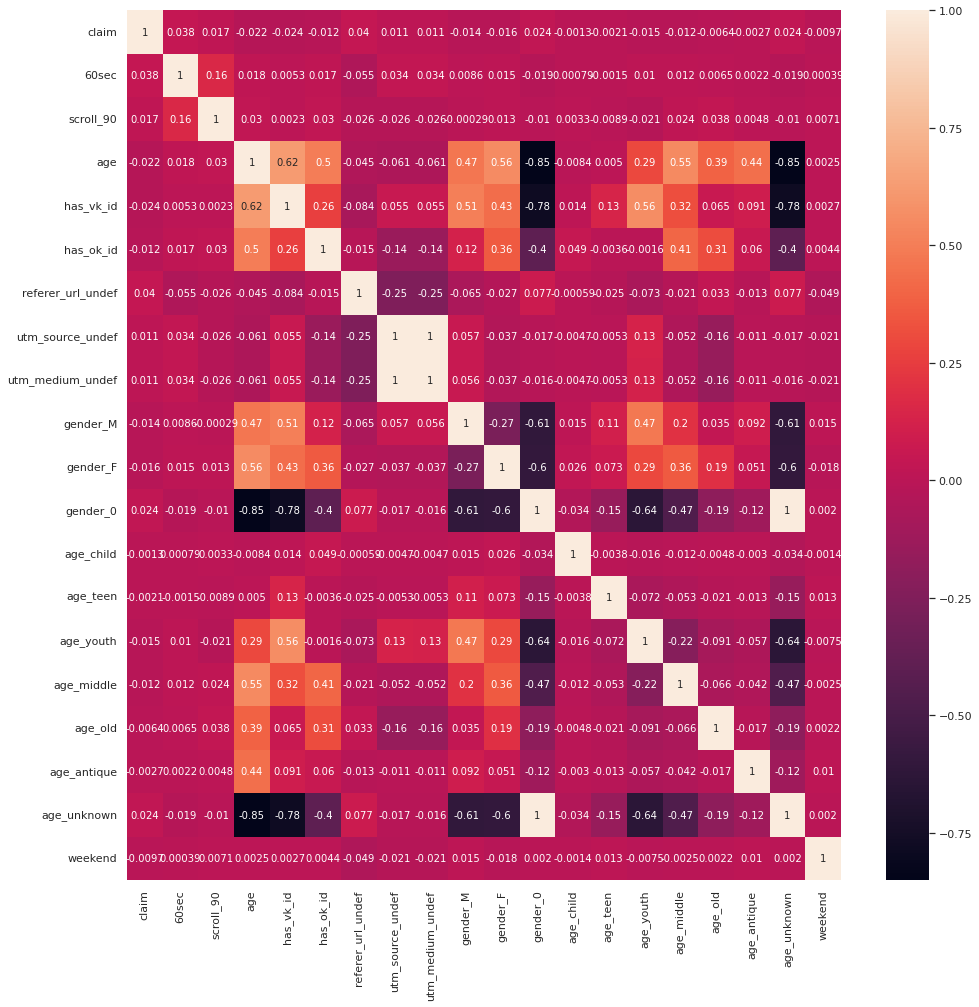

In [50]:
plt.figure(figsize=(16, 16))
sns.heatmap(gb_data.corr(), annot=True);

# 5. Построение воронки клиентов

Воронка продаж — это аналитический инструмент, который позволяет понять, как ваш потенциальный клиент приходит к решению о покупке ваших товаров или услуг.  
В рамках проекта нужно:
* Провести обработку поля 'referer_url’ и выделить категории (посещение урока, поиск, вход в личный кабинет и так далее).
* Определить, какие события будут показателями того, что клиент доволен сервисом.
* Сформулировать выводы по проведённому анализу.

In [51]:
# ...

# 6. Выявление инсайтов в данных

На какие вопросы ищем ответы:
* Какие действия клиенты GB совершают чаще всего?
* Есть ли аномалии в поведении пользователей: например, большое число коротких (менее 60 с.) сессий? С чем эти аномалии могут быть связаны?
* На каких страницах прокрутка 90% и более?
* В какие даты было больше всего сессий? Рассчитайте DAU, MAU, WAU (*среднестатистическое число уникальных пользователей за день, за неделю и за месяц соответственно*).
* Какие изменения на сайте могут улучшить показатели: число посещений, длительность сессии и другие?

In [52]:
# ...

In [53]:
# claim_0_rate = sum(gb_data['claim'] == 0) / len(gb_data)
# claim_1_rate = sum(gb_data['claim'] == 1) / len(gb_data)
# print(claim_0_rate, claim_1_rate)

In [54]:
# TARGET = 'claim'
# X = gb_data.drop(TARGET, axis=1)
# y = gb_data[TARGET]

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [56]:
# mod_cols = ['touch_screen']  # 'url_len'
# scaler = MinMaxScaler().fit(X_train[mod_cols])
# X_train[mod_cols] = scaler.transform(X_train[mod_cols])
# X_test[mod_cols] = scaler.transform(X_test[mod_cols])

In [57]:
# pd.DataFrame(data=X_train, columns=X.select_dtypes(exclude='object').columns).describe()

In [58]:
# # model = LogisticRegression(random_state=42, class_weight='balanced')
# # model = LinearSVC(random_state=42, class_weight='balanced')
# model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# # model = ComplementNB()
# # model = SVC(random_state=42, max_iter=2000, gamma='auto', class_weight='balanced')
# # model = SGDClassifier()

# # model = xgb.XGBClassifier(random_state=42)
# # model = lgbm.LGBMClassifier(random_state=42, class_weight='balanced')
# # model = catb.CatBoostClassifier(silent=True, random_state=42, auto_class_weights='Balanced')

# sample_weights = None  # compute_sample_weight(class_weight='balanced', y=y_train)
# model.fit(X_train, y_train, sample_weight=sample_weights)